In [53]:
import cv2
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm

In [1]:
def load_annotations(annotation_file):
    with open(annotation_file, 'r') as f:
        data = json.load(f)

    annotations = []
    base_image_path = ##redacted
    image_path = os.path.normpath(os.path.join(base_image_path, data['asset']['path'].lstrip('/\\')))
    for region in data['regions']:
        bbox = region['boundingBox']
        label = region['tags'][0] if region['tags'] else 'unknown'
        annotations.append({
            'image_path': image_path,
            'bbox': (int(bbox['left']), int(bbox['top']), int(bbox['width']), int(bbox['height'])),
            'label': label
        })

    return annotations


# Example usage
annotation_file = ## redacted
annotations = load_annotations(annotation_file)



SyntaxError: invalid syntax (3637399833.py, line 6)

In [79]:
def expand_to_square_and_resize(image, bbox, min_size=224):
    x, y, w, h = bbox
    # Calculate the size of the square
    side_length = max(w, h, min_size)

    # Calculate the center of the bounding box
    center_x = x + w // 2
    center_y = y + h // 2

    # Calculate the new top-left corner of the square
    new_x = center_x - side_length // 2
    new_y = center_y - side_length // 2

    # Ensure the new box is within the image bounds
    new_x = max(0, min(new_x, image.shape[1] - side_length))
    new_y = max(0, min(new_y, image.shape[0] - side_length))

    # Crop the square region
    cropped_image = image[new_y:new_y+side_length, new_x:new_x+side_length]

    # Resize to ensure the minimum size is 224x224
    if cropped_image.shape[0] < min_size or cropped_image.shape[1] < min_size:
        cropped_image = cv2.resize(cropped_image, (min_size, min_size))

    return cropped_image, (new_x, new_y, side_length, side_length)

Original image resolution: 3072x2304


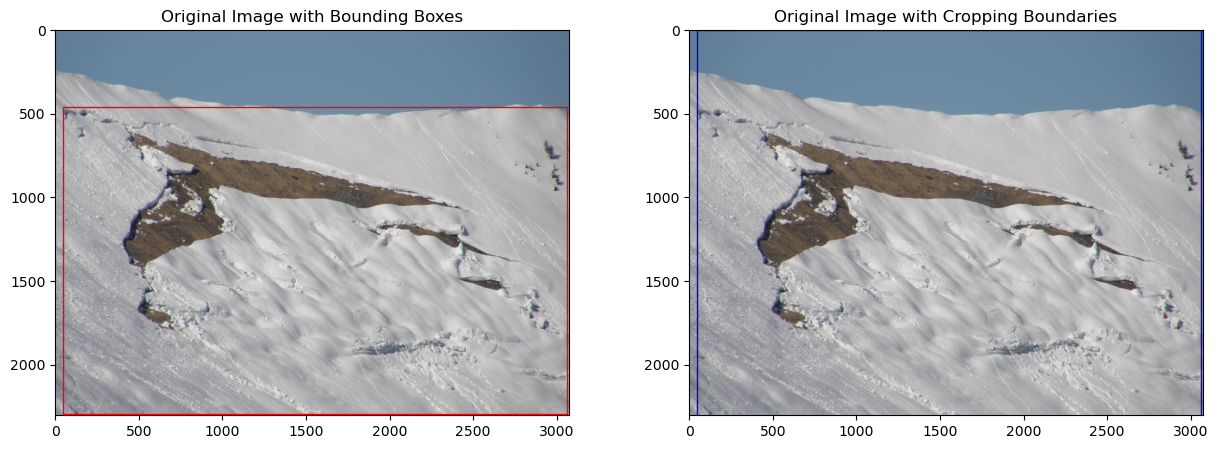

Cropped image 1 resolution: 3016x2304


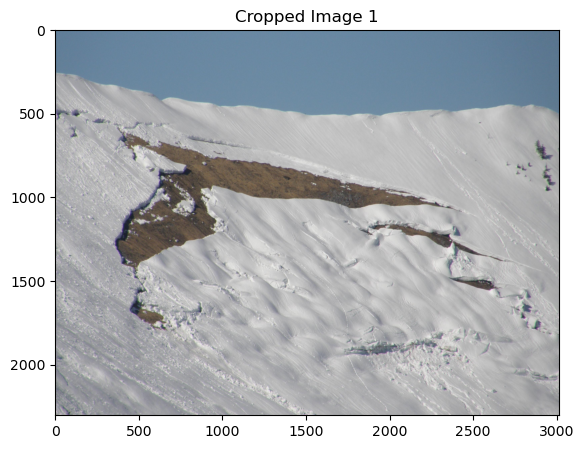

In [80]:
# Visualize cropping on a few images
annotation_file = ##redacted
show_cropped_example(annotation_file)

In [45]:
def show_cropped_example(annotation_file):
    annotations = load_annotations(annotation_file)
    if not annotations:
        print("No annotations found.")
        return
    
    # Load the original image
    first_annotation = annotations[0]
    image_path = first_annotation['image_path']
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read image {image_path}")
        return

    # Print resolution of the original image
    print(f"Original image resolution: {image.shape[1]}x{image.shape[0]}")

    # Figure 1: Plot the original image with all bounding boxes and cropping boundaries
    fig1, axes1 = plt.subplots(1, 2, figsize=(15, 5))

    # Original image with annotation-based bounding boxes
    axes1[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes1[0].set_title("Original Image with Bounding Boxes")
    for annotation in annotations:
        x, y, w, h = annotation['bbox']
        rect = plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        axes1[0].add_patch(rect)

    # Original image with cropping boundaries
    axes1[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes1[1].set_title("Original Image with Cropping Boundaries")
    for annotation in annotations:
        _, cropping_bbox = expand_to_square_and_resize(image, annotation['bbox'])
        x, y, w, h = cropping_bbox
        rect = plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='b', facecolor='none')
        axes1[1].add_patch(rect)

    plt.show()

    # Figure 2: Plot each cropped image and print their resolutions
    fig2, axes2 = plt.subplots(1, len(annotations), figsize=(15, 5))
    if len(annotations) == 1:
        axes2 = [axes2]  # Ensure axes2 is iterable if there's only one cropped image

    for i, annotation in enumerate(annotations):
        cropped_image, _ = expand_to_square_and_resize(image, annotation['bbox'])
        print(f"Cropped image {i + 1} resolution: {cropped_image.shape[1]}x{cropped_image.shape[0]}")
        axes2[i].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
        axes2[i].set_title(f"Cropped Image {i + 1}")

    plt.show()

Original image resolution: 735x796


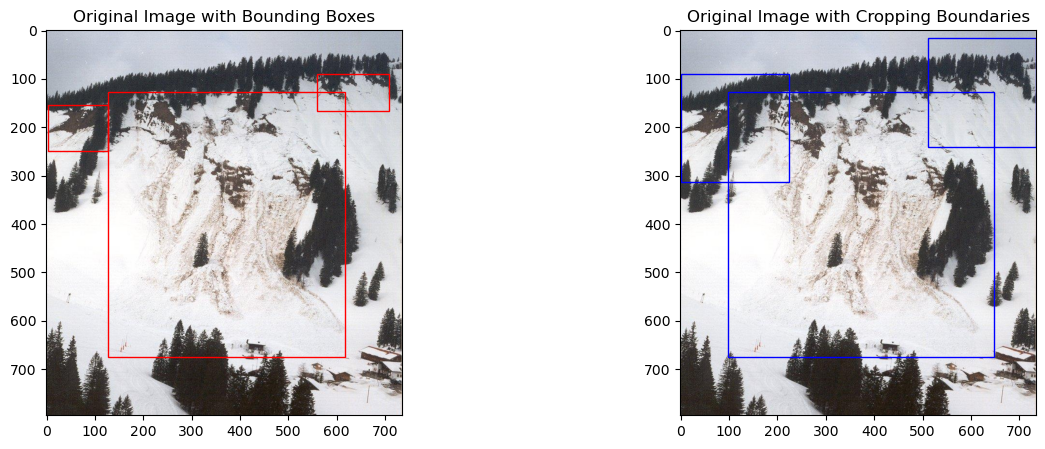

Cropped image 1 resolution: 224x224
Cropped image 2 resolution: 549x549
Cropped image 3 resolution: 224x224


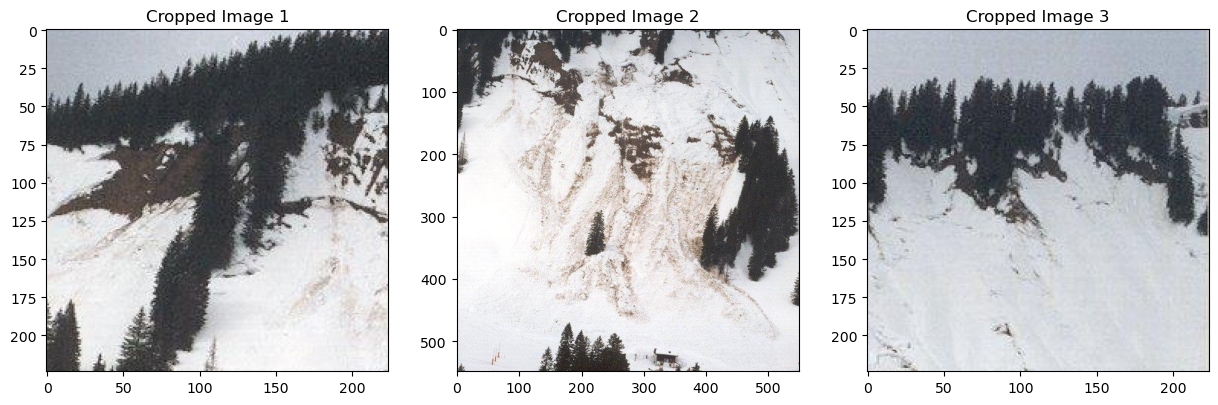

In [81]:
# Visualize cropping on a few images
annotation_file = ##redacted
show_cropped_example(annotation_file)

Original image resolution: 3000x4000


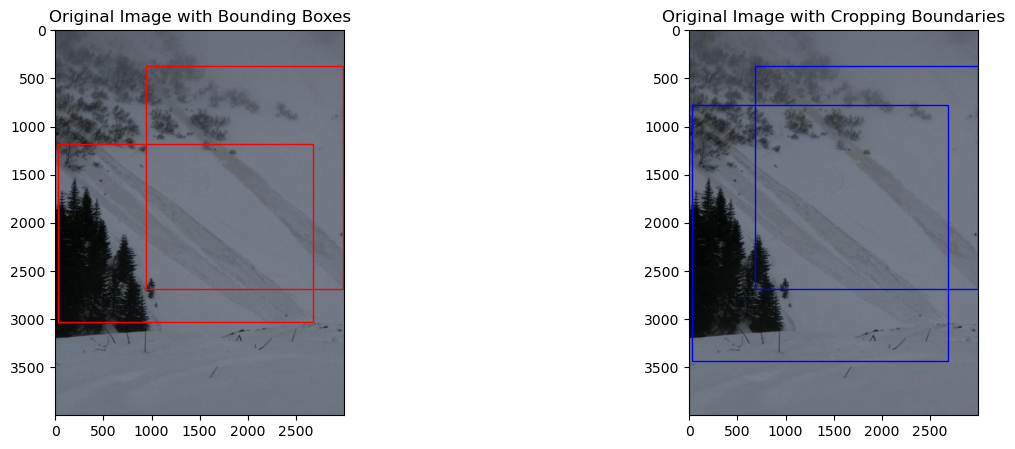

Cropped image 1 resolution: 2658x2658
Cropped image 2 resolution: 2314x2314


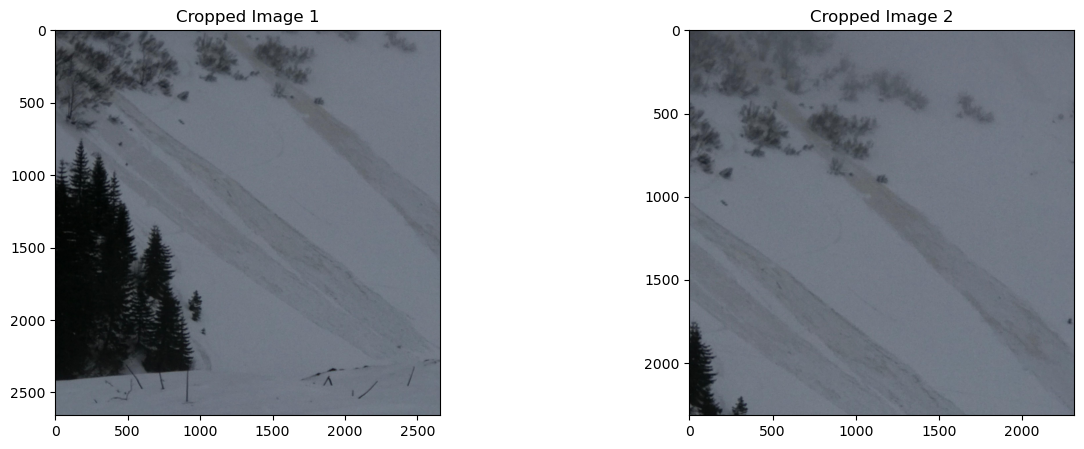

In [82]:
# Visualize cropping on a few images
annotation_file = ##redacted
show_cropped_example(annotation_file)

Original image resolution: 5184x3456


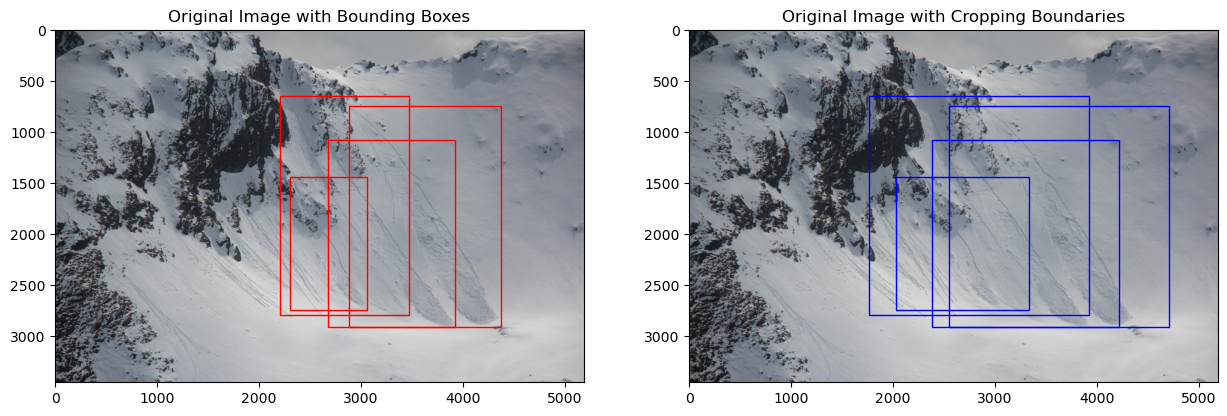

Cropped image 1 resolution: 1308x1308
Cropped image 2 resolution: 2155x2155
Cropped image 3 resolution: 1830x1830
Cropped image 4 resolution: 2166x2166


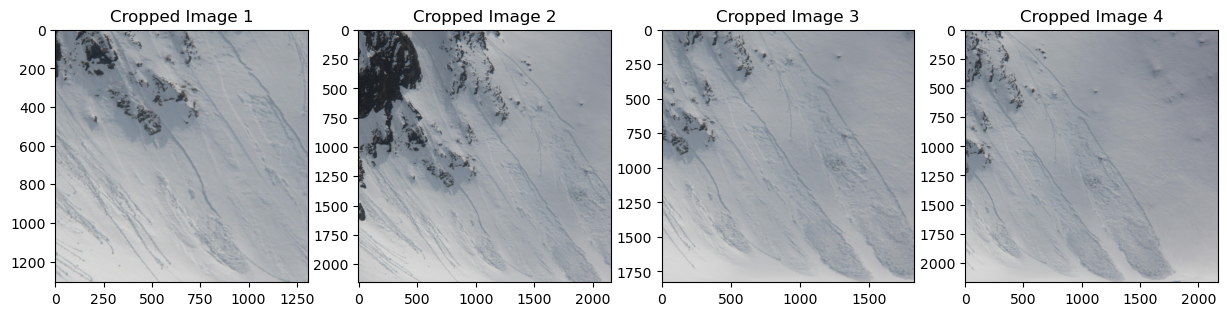

In [83]:
# Visualize cropping on a few images
annotation_file =##redacted
show_cropped_example(annotation_file)

Original image resolution: 5184x3456


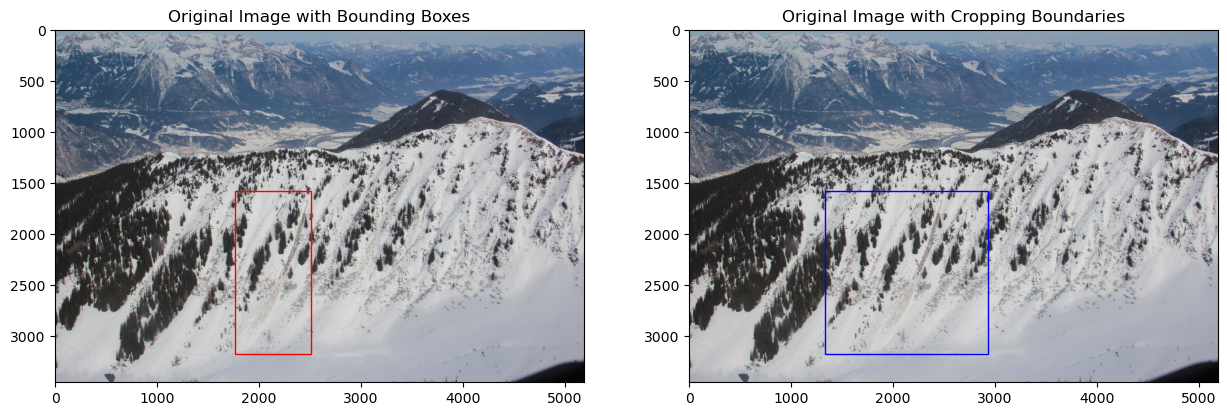

Cropped image 1 resolution: 1597x1597


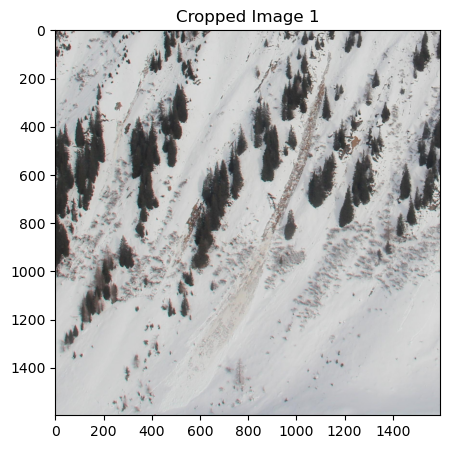

In [84]:
# Visualize cropping on a few images
annotation_file = ##redacted
show_cropped_example(annotation_file)

Original image resolution: 3072x2304


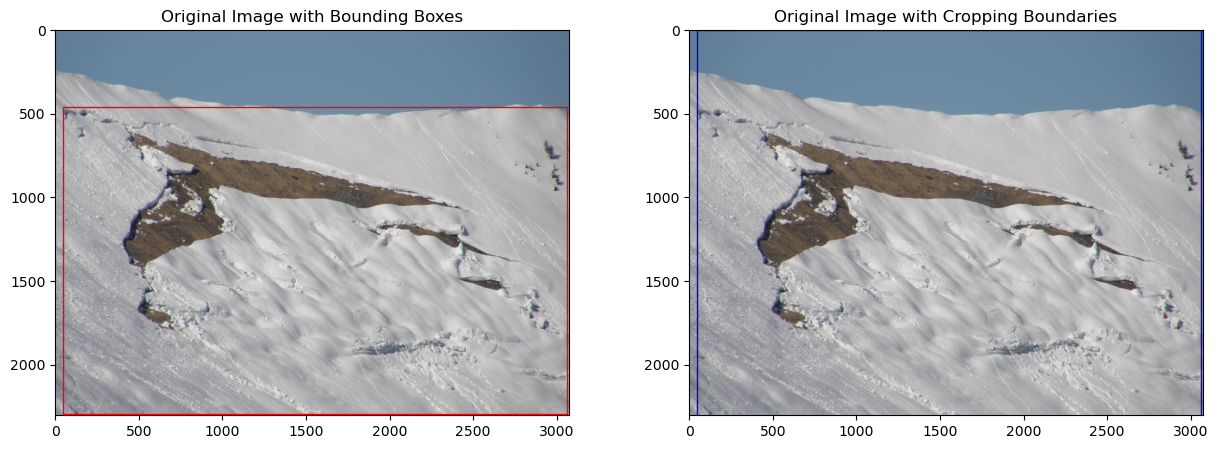

Cropped image 1 resolution: 3016x2304


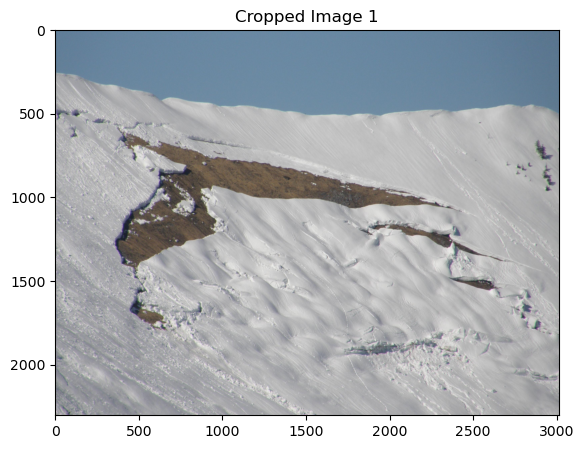

In [85]:
# Visualize cropping on a few images
annotation_file = ##redacted
show_cropped_example(annotation_file)

## Batch crop all images

In [86]:
def find_annotation_files(annotation_dir):
    annotation_files = []
    for root, _, files in os.walk(annotation_dir):
        for file in files:
            if file.endswith('.json'):
                annotation_files.append(os.path.join(root, file))
    return annotation_files

def create_cropped_dataset(annotation_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    annotation_files = find_annotation_files(annotation_dir)
    total_images = sum(len(load_annotations(f)) for f in annotation_files)

    with tqdm(total=total_images, desc="Processing all images") as pbar:
        for annotation_file in annotation_files:
            annotations = load_annotations(annotation_file)
            if not annotations:
                print(f"No annotations found in {annotation_file}.")
                continue
            
            # Load the original image
            first_annotation = annotations[0]
            image_path = os.path.normpath( first_annotation['image_path'])
            image = cv2.imread(image_path)
            if image is None:
                print(f"Could not read image {image_path}")
                pbar.update(len(annotations))
                continue

            for i, annotation in enumerate(annotations):
                cropped_image, crop_box = expand_to_square_and_resize(image, annotation['bbox'])
                label = annotation['label']
                label_dir = os.path.join(output_dir, label)
                if not os.path.exists(label_dir):
                    os.makedirs(label_dir)
                output_path = os.path.join(label_dir, f"{os.path.splitext(os.path.basename(annotation_file))[0]}_{i + 1}.jpg")
                if cropped_image is not None:
                    cv2.imwrite(output_path, cropped_image)
                    #print(f"Saved cropped image to {output_path}")
                else:
                    print(f"Could not crop image for annotation {annotation} in file {annotation_file}")
                pbar.update(1)

In [88]:
# Example usage
annotation_dir = ##redacted
output_dir = ##redacted  
create_cropped_dataset(annotation_dir, output_dir)

Processing all images: 100%|██████████| 7228/7228 [05:07<00:00, 23.53it/s]


In [89]:
# Print the number of files in each label directory
print("\nCropped Dataset summary:")
for label in os.listdir(output_dir):
    label_dir = os.path.join(output_dir, label)
    if os.path.isdir(label_dir):
        num_files = len(os.listdir(label_dir))
        print(f"Label '{label}': {num_files} files")


Cropped Dataset summary:
Label 'glide': 2489 files
Label 'loose': 1827 files
Label 'slab': 2912 files
